In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -q -U git+https://github.com/sbrugman/SDGym.git@v0.2.2-hw

In [ ]:
!pip install -q -U ../../

In [2]:
from timeit import default_timer as timer
from functools import partial
from random import choices
import logging

In [3]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark
from sdgym import load_dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
import pgmpy

from pgmpy.models import BayesianModel
from pgmpy.estimators import TreeSearch, HillClimbSearch, BicScore, ExhaustiveSearch, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

In [8]:
from scipy import interpolate

In [9]:
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
logging.basicConfig(level=logging.INFO)

In [12]:
dataset_name = 'credit'

In [13]:
data, categorical_columns, ordinal_columns = load_dataset(dataset_name)

INFO:sdgym.data:Loading dataset credit (all variables, -1 distinct values threshold)
INFO:sdgym.data:Columns to zero-code: []


In [14]:
data.shape

(264807, 30)

In [15]:
categorical_columns, ordinal_columns

([29], [])

In [16]:
for i in range(data.shape[1]):
    print (i, len(np.unique(data[:, i])))

0 255491
1 256211
2 256139
3 256197
4 256261
5 256151
6 256231
7 256279
8 256251
9 256227
10 256108
11 256202
12 256207
13 256266
14 256195
15 256188
16 256195
17 256249
18 256225
19 256215
20 256218
21 256145
22 256228
23 256177
24 256147
25 256190
26 256316
27 256286
28 31584
29 2


In [17]:
u, c = np.unique(data[:, 29], return_counts=True)

In [18]:
u, c

(array([0., 1.], dtype=float32), array([264350,    457]))

In [19]:
X0 = data[data[:, 29]==0][:, range(29)]
X1 = data[data[:, 29]==1][:, range(29)]


In [20]:
X1.shape

(457, 29)

In [21]:
for i in range(X1.shape[1]):
    print (i, len(np.unique(X1[:, i])))

0 440
1 440
2 440
3 440
4 440
5 440
6 440
7 440
8 440
9 440
10 440
11 440
12 440
13 440
14 440
15 440
16 440
17 440
18 440
19 440
20 440
21 440
22 440
23 440
24 440
25 440
26 440
27 440
28 241


In [34]:
kde = KDECopulaNNPdf(
    n_quantiles=100,
    use_KDE=False, 
    # categorical_columns=categorical_columns+ordinal_columns,
    distinct_threshold=-1,
    n_uniform_bins=10,
    n_calibration_bins=20,
#        clf=clf,
#         n_quantiles=100
#         ordering='mi',
)
kde = kde.fit(X1)


INFO:KDECopulaNNPdf:Processing 29 numerical and 0 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 250000 data points.
Generating for node: 2: 100%|██████████| 29/29 [00:05<00:00,  5.03it/s] 
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 29 features.
INFO:KDECopulaNNPdf:Calibrating classifier.
INFO:KDECopulaNNPdf:Maximum weight found: 1.590677725971067


INFO:KDECopulaNNPdf:Maximum weight found: 1.590677725971067


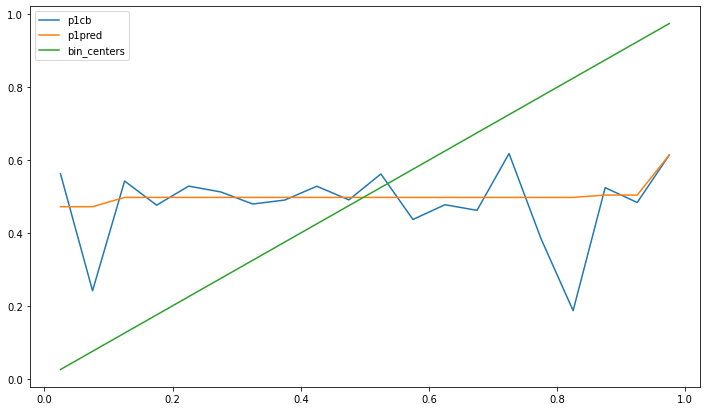

In [35]:
kde._calibrate_classifier(kde.hist_p0_, kde.hist_p1_, kde.bin_edges_, validation_plots=True)

In [72]:
X1_gen = kde.sample_no_weights(X1.shape[0], mode='ignore_weights', show_progress=True)

INFO:KDECopulaNNPdf:Generating 457 data points.
Generating for node: 16: 100%|██████████| 29/29 [00:00<00:00, 55.10it/s]


In [41]:
kde0 = KDECopulaNNPdf(
    n_quantiles=500,
    use_KDE=False, 
    # categorical_columns=categorical_columns+ordinal_columns,
    distinct_threshold=-1,
    n_uniform_bins=25,
#        clf=clf,
#         n_quantiles=100
#         ordering='mi',
)
kde0 = kde.fit(X0)


INFO:KDECopulaNNPdf:Processing 29 numerical and 0 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 264350 data points.
Generating for node: 16: 100%|██████████| 29/29 [00:06<00:00,  4.66it/s]
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 29 features.
INFO:KDECopulaNNPdf:Calibrating classifier.
INFO:KDECopulaNNPdf:Maximum weight found: 1220.6715939707274


In [73]:
X0_gen = kde0.sample_no_weights(X0.shape[0], mode='cheap', show_progress=True)

INFO:KDECopulaNNPdf:Generating 264350 data points.
Generating for node: 16: 100%|██████████| 29/29 [00:06<00:00,  4.53it/s]


In [74]:
X1_gen = np.concatenate([X1_gen, np.ones(X1.shape[0]).reshape(-1, 1)], axis=1)

In [75]:
X0_gen = np.concatenate([X0_gen, np.zeros(X0.shape[0]).reshape(-1, 1)], axis=1)

In [76]:
X_gen = np.concatenate([X0_gen, X1_gen], axis=0)

In [98]:
X_gen.shape, data.shape

((264807, 30), (264807, 30))

In [99]:
import pandas as pd

In [100]:
df = pd.DataFrame(data)

In [101]:
df.to_csv('credit_gen.csv', index=False)

# run sdgym

In [104]:
def KDECopulaNNPdf_csv(real_data, categorical_columns, ordinal_columns):
    df = pd.read_csv('credit_gen.csv')
    X_gen = df.values

    print(X_gen[:, :5])

    return X_gen

In [93]:
def KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns):
    #assert len(categorical_columns + ordinal_columns) <= 1

    all_features = list(range(real_data.shape[1]))
    numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))
    data = np.float64(real_data)
    
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        reg_lambda=1,
        gamma=0,
        max_depth=9
    )
#     clf = MLPClassifier(alpha=0.1, random_state=0, max_iter=1000, early_stopping=True)
    
    kde = KDECopulaNNPdf(
        use_KDE=False, 
        categorical_columns=categorical_columns+ordinal_columns,
        distinct_threshold=-1,
        n_bins=25,
#        clf=clf,
#         n_quantiles=100
#         ordering='mi',
    )
    kde = kde.fit(data)
    
#     X_gen, sample_weight = kde.sample(n_samples)
    X_gen = kde.sample_no_weights(n_samples, show_progress=True, mode='cheap')
    
    X_gen[:, categorical_columns+ordinal_columns] = np.round(X_gen[:, categorical_columns+ordinal_columns])
    X_gen = np.float32(X_gen)
    
    print(X_gen[:, :5])

    return X_gen

In [94]:
def KDECopulaNNPdf_SynthesizerInteger(real_data, categorical_columns, ordinal_columns):
    data = KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns)
    data = np.round(data)
    
    print(data[:, :5])

    return data

In [109]:
from sdgym.synthesizers import (
    CLBNSynthesizer, CTGANSynthesizer, IdentitySynthesizer, IndependentSynthesizer,
    MedganSynthesizer, PrivBNSynthesizer, TableganSynthesizer, TVAESynthesizer,
    UniformSynthesizer, VEEGANSynthesizer)

all_synthesizers = [
#    IdentitySynthesizer,
#    IndependentSynthesizer,
#    KDECopulaNNPdf_Synthesizer,
#     KDECopulaNNPdf_SynthesizerInteger,
    KDECopulaNNPdf_csv,
]

In [110]:
scores = sdgym.run(synthesizers=all_synthesizers, datasets=[dataset_name], iterations=1)

INFO:sdgym.benchmark:0%|          | 0/2 [00:00<?, ?it/s]
INFO:sdgym.benchmark:Evaluating KDECopulaNNPdf_csv on dataset credit; iteration 0; 1.08 GB
INFO:sdgym.data:Loading dataset credit (all variables, -1 distinct values threshold)
INFO:sdgym.data:Columns to zero-code: []
INFO:sdgym.benchmark:Running KDECopulaNNPdf_csv on dataset credit; iteration 0; 930.07 MB
INFO:sdgym.benchmark:Scoring KDECopulaNNPdf_csv on dataset credit; iteration 0; 1 GB


[[-0.32333356  1.0574553  -0.04834115 -0.6072043   1.2598212 ]
 [-0.3497184   0.93261856  0.14299203 -0.65707123  1.1697835 ]
 [-1.6147108  -2.4065697   0.32619393  0.6655196   2.3692677 ]
 ...
 [ 1.7534014  -0.54023844 -0.99612343  0.45971587 -0.10766458]
 [-0.7671734   1.0007492  -1.2829502  -1.8476053   0.06988677]
 [ 1.9446427  -0.5182767   0.1387495   0.38508523 -0.8516984 ]]


INFO:sdgym.evaluate:Evaluating using binary classifier DecisionTreeClassifier
INFO:sdgym.evaluate:Evaluating using binary classifier AdaBoostClassifier
INFO:sdgym.evaluate:Evaluating using binary classifier LogisticRegression
INFO:sdgym.evaluate:Evaluating using binary classifier MLPClassifier
INFO:sdgym.benchmark:Finished KDECopulaNNPdf_csv on dataset credit; iteration 0; 1.1 GB
INFO:sdgym.benchmark:50%|#####     | 1/2 [00:52<00:52, 52.89s/it]
INFO:sdgym.benchmark:Evaluating KDECopulaNNPdf_data on dataset credit; iteration 0; 1.09 GB
INFO:sdgym.data:Loading dataset credit (all variables, -1 distinct values threshold)
INFO:sdgym.data:Columns to zero-code: []
INFO:sdgym.benchmark:Running KDECopulaNNPdf_data on dataset credit; iteration 0; 930.07 MB
INFO:sdgym.benchmark:Scoring KDECopulaNNPdf_data on dataset credit; iteration 0; 1 GB


[[-0.32333356  1.0574553  -0.04834115 -0.6072043   1.2598212 ]
 [-0.3497184   0.93261856  0.14299203 -0.65707123  1.1697835 ]
 [-1.6147108  -2.4065697   0.32619393  0.6655196   2.3692677 ]
 ...
 [ 1.7534014  -0.54023844 -0.99612343  0.45971587 -0.10766458]
 [-0.7671734   1.0007492  -1.2829502  -1.8476053   0.06988677]
 [ 1.9446427  -0.5182767   0.1387495   0.38508523 -0.8516984 ]]


INFO:sdgym.evaluate:Evaluating using binary classifier DecisionTreeClassifier
INFO:sdgym.evaluate:Evaluating using binary classifier AdaBoostClassifier
INFO:sdgym.evaluate:Evaluating using binary classifier LogisticRegression
INFO:sdgym.evaluate:Evaluating using binary classifier MLPClassifier
INFO:sdgym.benchmark:Finished KDECopulaNNPdf_data on dataset credit; iteration 0; 1.1 GB
INFO:sdgym.benchmark:100%|##########| 2/2 [01:43<00:00, 51.60s/it]


In [111]:
scores

,credit/accuracy,credit/f1,timestamp
VEEGANSynthesizer,0.876258,0.166030,2020-04-12 09:41:35.096775
CLBNSynthesizer,0.997938,0.440643,2020-10-17 09:46:54.494331
CTGAN,0.997733,0.659771,2020-10-17 09:46:54.494331
CTGANSynthesizer,0.993329,0.523338,2020-10-17 09:46:54.494331
CopulaGAN,0.998663,0.717449,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,0.998250,0.000000,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,0.981504,0.010344,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,0.998250,0.000000,2020-10-17 09:46:54.494331
IdentitySynthesizer,0.992483,0.545018,2020-10-17 09:46:54.494331
IndependentSynthesizer,0.875417,0.001836,2020-10-17 09:46:54.494331
